In [18]:
from tensorflow import keras
from pathlib import Path
import argparse
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.misc import triplet_to_str
from preprocessing.database import clean_database, download_database
from preprocessing.sets import preprocess_data
from knn.knn import KNN, test_KNN

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', help='Path to the config file', default='./default_config.yml')
parser.add_argument('--log-dir', help='Path to the log directory', default='../log/')
parser.add_argument('--posters', help='Path to the posters', default='../data/posters/')
parser.add_argument('--models-dir', help='Path to the saved models', default='../data/models/')
parser.add_argument('--sets-dir', help='Path to the training and testing sets', default='../data/sets/')
parser.add_argument('--database', help='Path to the databse csv', default='../data/poster_data.csv')
parser.add_argument('--csv', help='Path to the clean csv', default='../data/')
parser.add_argument('-s', '--save', help='Save model', action='store_true')
parser.add_argument('-v', '--verbose', help='Verbose', action='store_true')

str_args = '-v -s'.split()
args, _ = parser.parse_known_args(str_args)

logger = None

In [3]:
config = yaml.safe_load(open(args.config, encoding='utf-8'))

nb_genres = len(config["genres"])
input_size = config["image_size"]

In [4]:
appendix_split = 's{}t{}_'.format(
    config['size_per_genre'],
    config['testing_split']
) + triplet_to_str(config['image_size']) + '_' + str(nb_genres) + ".npy"

data_name = [Path(prefix+appendix_split) for prefix in
    [args.sets_dir + 'xtr_',
    args.sets_dir + 'ytr_',
    args.sets_dir + 'idtr_',
    args.sets_dir + 'xtest_',
    args.sets_dir + 'ytest_',
    args.sets_dir + 'idtest_']
]

In [5]:
data_name[0]

WindowsPath('../data/sets/xtr_s700t0.15_100-100-3_7.npy')

In [6]:
selection_name = args.csv+'clean_poster_data_'+str(nb_genres)+'.csv'

if Path(selection_name).exists():
    if args.verbose:
        print('Database already cleaned')
    clean_movies = pd.read_csv(Path(selection_name))
else:
    clean_movies = clean_database(Path(args.database))
    if args.save:
        clean_movies.to_csv(Path(selection_name))

Database already cleaned


In [7]:
if data_name[0].exists() and data_name[1].exists() and data_name[2].exists() and data_name[3].exists() and data_name[4].exists() and data_name[5].exists():
    if args.verbose:
        print('Training and testing sets already made')
    train_posters, train_genres, train_ids = np.load(data_name[0]), np.load(data_name[1]), np.load(data_name[2])
    test_posters, test_genres, test_ids = np.load(data_name[3]), np.load(data_name[4]), np.load(data_name[5])

else:
    train_posters, train_genres, train_ids, test_posters, test_genres, test_ids = preprocess_data(
        clean_movies, config['genres'], config['size_per_genre'], args.posters, config['image_size'],
        config['seed'], testing_split=config['testing_split'], verbose=args.verbose, logger=logger
    )
    if args.save:
        sets_path = Path(args.sets_dir)
        if not sets_path.exists():
            sets_path.mkdir()
        np.save(data_name[0], train_posters)
        np.save(data_name[1], train_genres)
        np.save(data_name[2], train_ids)
        np.save(data_name[3], test_posters)
        np.save(data_name[4], test_genres)
        np.save(data_name[5], test_ids)

Training and testing sets already made


In [10]:
resnet = keras.applications.resnet_v2.ResNet50V2(
    input_shape=input_size, include_top=False, weights="imagenet"
)

In [11]:
train_features = resnet.predict(train_posters.astype(np.float32)).reshape(
    (len(train_posters), -1)
)
    
test_features = resnet.predict(test_posters.astype(np.float32)).reshape(
    (len(test_posters), -1)
)

In [12]:
# SAUVEGARDER LES FEATURES

<class 'numpy.ndarray'>


Affichage des plus proches voisins sur un exemple

Calcul des prédictions sur le testing set

In [25]:
k=5
predicted_genres = KNN(clean_movies, train_posters, train_features, train_genres, train_ids, test_posters, test_features, test_ids, -1, k, print_results=False)

Generating kNN Classifier...


  0%|                                                                                          | 0/734 [00:00<?, ?it/s]

Generating of the classifier done.
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


100%|████████████████████████████████████████████████████████████████████████████████| 734/734 [03:34<00:00,  3.42it/s]


genres ['Action', 'Animation', 'Comédie', 'Comédie dramatique', 'Documentaire', 'Drame', 'Thriller-Policier']
accuracy: 0.30926430517711173


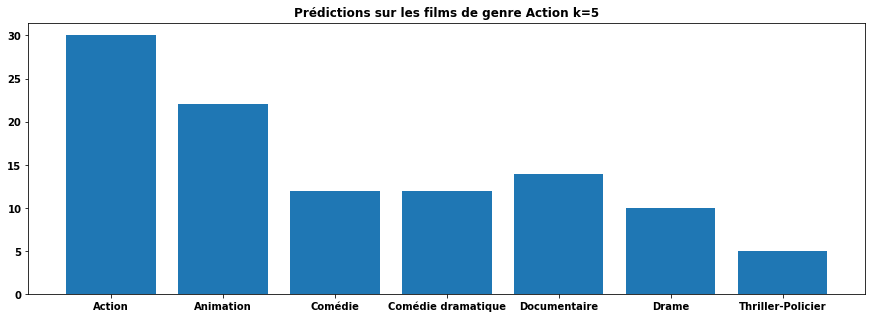

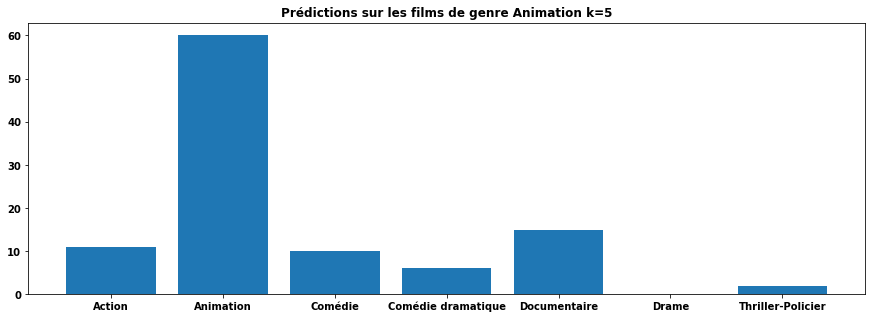

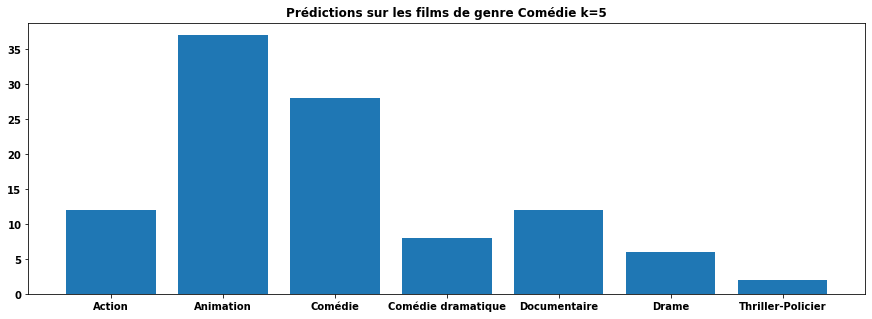

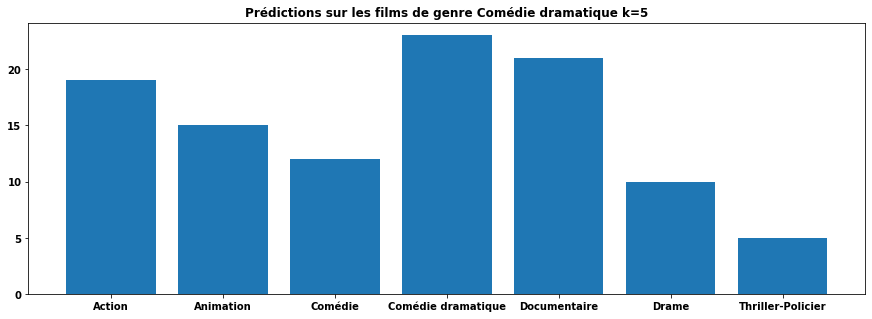

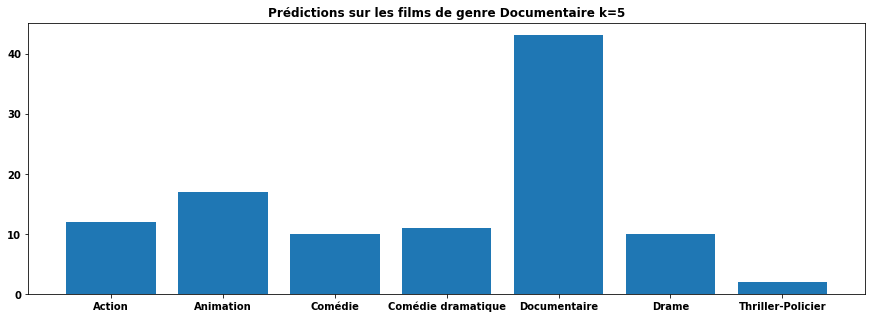

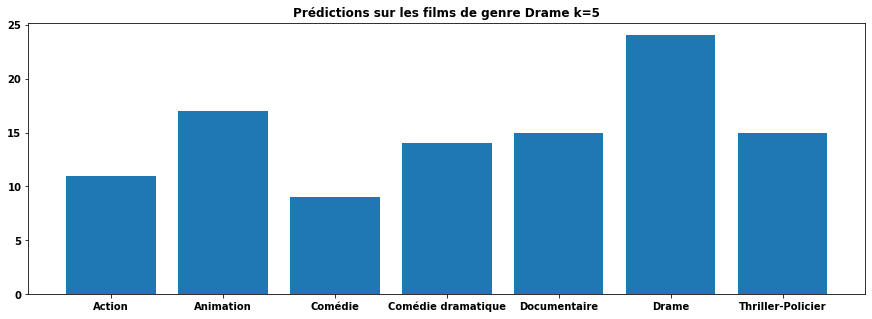

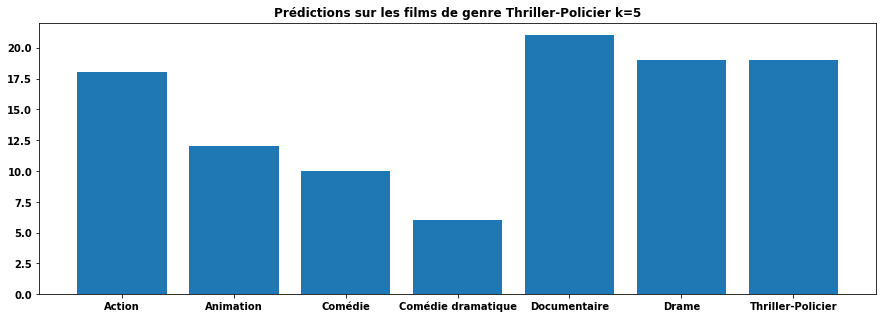

0

In [27]:
genres_inv = {config['genres'][k]: k for k in config['genres'].keys()}
print('genres', list(config['genres']))

def visualisation_resultats(predicted_genres, test_genres):
    predictions = np.array([genres_inv[k] for k in np.argmax(predicted_genres, axis=1)])
    ground_truth = np.array([genres_inv[k] for k in np.argmax(test_genres, axis=1)])

    genres = config["genres"]
    # results_per_genre : matrice donc les lignes sont les vrais genres, et les colonnes sont les genres prédits
    results_per_genre = {
        genre_true : {genre_pred : 0 for genre_pred in genres}
        for genre_true in genres
    }
    #print("results per genre", results_per_genre)
    #print('results per genre ligne', results_per_genre['Action'].values())
    # total_per_genre : vecteur qui comptabilise le nombre de représentants de chaque genre
    total_per_genre = {
        genre : 0
        for genre in genres
    }
    # Mise à jour de results_per_genre et total_per_genre en fonction des prédictions
    n = len(predictions)
    for i in range(n):
        results_per_genre[ground_truth[i]][predictions[i]] += 1
        total_per_genre[ground_truth[i]] += 1
        
    # Accuracy    
    accuracy = 0
    for genre in genres:
        accuracy += results_per_genre[genre][genre]
    accuracy /= len(test_posters)
    print('accuracy:', accuracy)

    # Visualisation:
    genres_list = list(config['genres'])
    for iterateur in genres_list:
        plt.figure(figsize=(15, 5))
        plt.title('Prédictions sur les films de genre ' + iterateur + ' k='+str(k))
        plt.bar(genres_list, results_per_genre[iterateur].values())
        plt.show()
  
    return(0)

visualisation_resultats(predicted_genres, test_genres)